<h1>Contrastive Learning</h1>
This example demonstrates how to implement a Contrastive Learning Siamese Network using Contrastive Loss to determine whether a pair of images are similar. Contrastive Loss was introduced by Yann Le Cunn et al. in the paper "Dimensionality Reduction by Learning an Invariant Mapping.".

![siamese-network.png](attachment:siamese-network.png)

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [2]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
X_train shape: (60000, 28, 28)
y_train shape: (60000,)


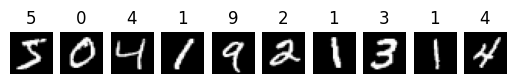

In [3]:
import matplotlib.pyplot as plt


for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (60000, 784)
X_test shape: (10000, 784)


In [5]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

![image.png](attachment:image.png)

In [7]:
X_train= X_train / 255.0
X_test= X_test / 255.0

In [8]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [9]:
import numpy as np

def generate_pairs(X, y):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image representing the same digit.
        # This is a positive pair.
        positive_digit_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[positive_digit_index]])

        # Since this is a positive pair, the ground truth label is 0.
        # The distance between images representing the same digit should be small,
        # and that's why we use 0 as the label.
        y_pairs.append([0])

        # Find a random image representing a different digit.
        # This is a negative pair.
        negative_digit_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list.
        X_pairs.append([X[i], X[negative_digit_index]])

        # Since this is a negative pair, the ground truth label is 1.
        # The distance between images representing different digits should be large,
        # and that's why we use 1 as the label.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [10]:
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs shape:", X_train_pairs.shape)
print("X_test_pairs shape:", X_test_pairs.shape)

X_train_pairs shape: (120000, 2, 784)
X_test_pairs shape: (20000, 2, 784)


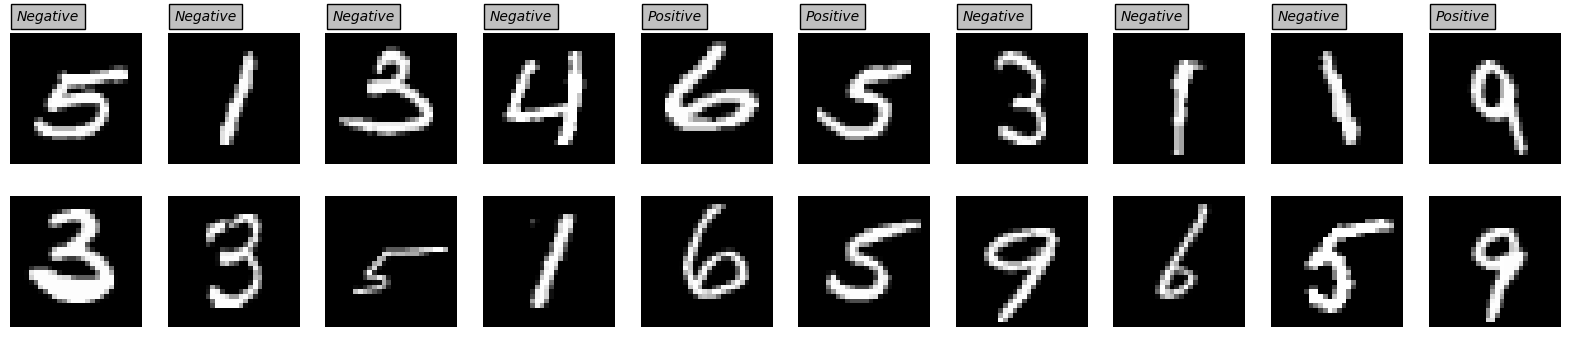

In [11]:
def display_pairs(X, y, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - X: An array containing the image pairs.
        - y: An array containing the corresponding label (0 if both
            pairs are the same, and 1 if both pairs are different.)
        - correct (optional): An array of boolean values indicating whether
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Same" if label == 0 else "Different"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1)
        ax.text(
            1,
            -3,
            text,
            style="italic",
            bbox={"facecolor": color, "pad": 4},
        )

        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


display_pairs(X_train_pairs, y_train_pairs)

In [12]:
from keras import Input

input1 =Input(shape=(784,))
input2=Input(shape=(784,))

In [13]:
from keras.layers import Dense
from keras.models import Sequential

network=Sequential(
    [
        Input(shape=(784,)),
        Dense(512,activation='relu'),
        Dense(256,activation='relu'),
        Dense(128,activation=None)
    ]
)

In [14]:
twin1=network(input1)
twin2=network(input2)

In [15]:


from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """Compute the euclidean distance (norm) of the output of
    the twin networks.
    """
    twin1_output, twin2_output = twins
    return norm(twin1_output - twin2_output, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

In [16]:
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

In [17]:
from keras.ops import cast, maximum, square


def contrastive_loss(y, d):
    """
    Compute the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping."
    """

    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

In [18]:
from keras.metrics import binary_accuracy

model.compile(loss=contrastive_loss, optimizer="adam", metrics=[binary_accuracy])

In [19]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 784)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │        566,144 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 566,144 (2.16 MB)

 Trainable params: 566,144 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

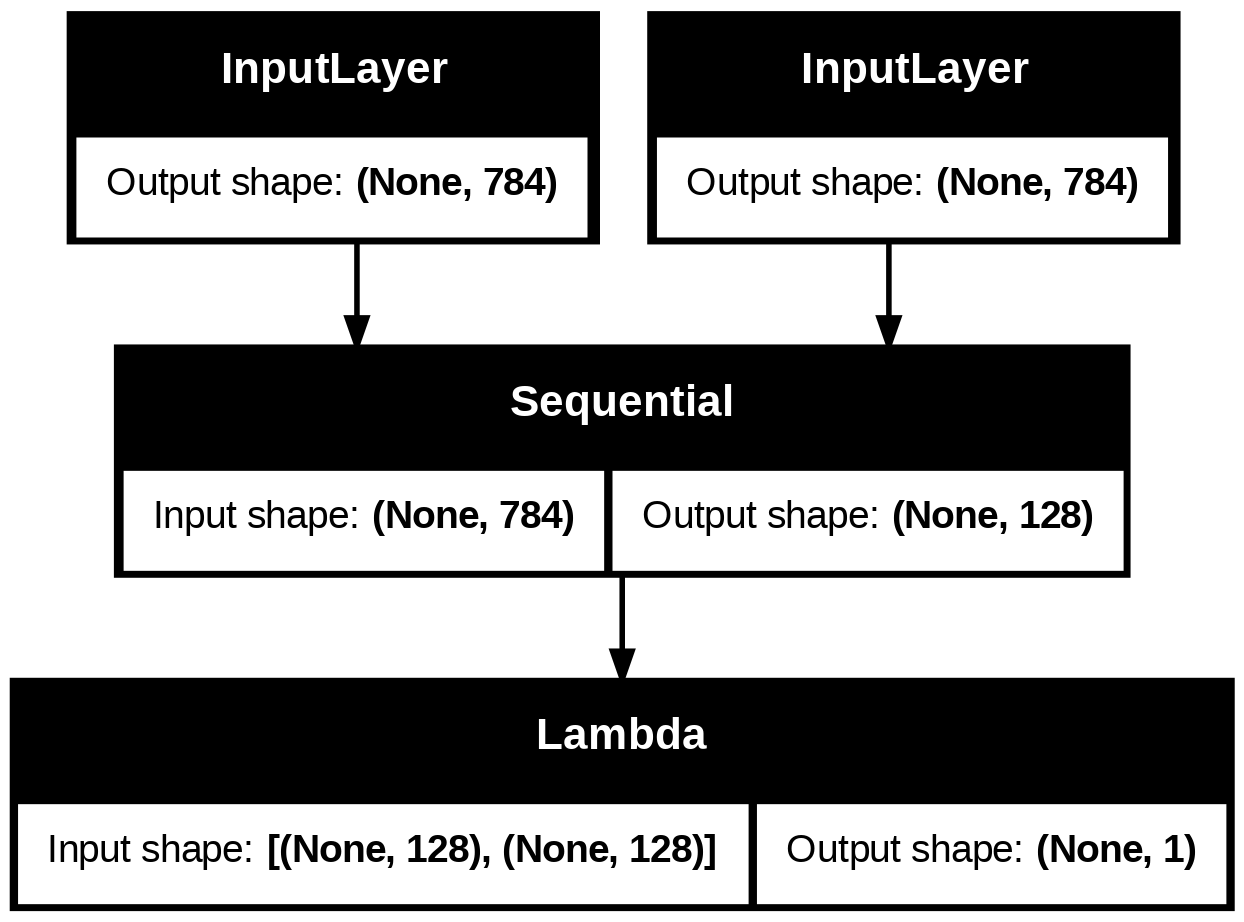

In [20]:
keras.utils.plot_model(
    model, to_file="model.png", show_shapes=True, show_layer_names=False
)

In [22]:
X_train_pairs.shape

(120000, 2, 784)

In [23]:

history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:],
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=5,
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 54s 14ms/step - binary_accuracy: 0.8917 - loss: 0.0500 - val_binary_accuracy: 0.9593 - val_loss: 0.0215
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - binary_accuracy: 0.9755 - loss: 0.0161 - val_binary_accuracy: 0.9669 - val_loss: 0.0182
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - binary_accuracy: 0.9851 - loss: 0.0109 - val_binary_accuracy: 0.9695 - val_loss: 0.0151
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - binary_accuracy: 0.9891 - loss: 0.0083 - val_binary_accuracy: 0.9669 - val_loss: 0.0151
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - binary_accuracy: 0.9920 - loss: 0.0067 - val_binary_accuracy: 0.9725 - val_loss: 0.0130


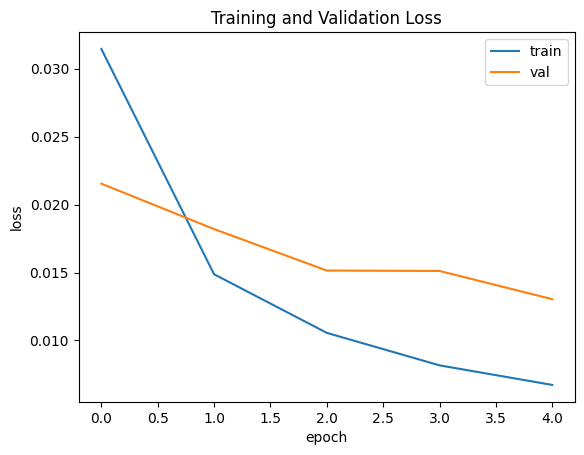

In [24]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


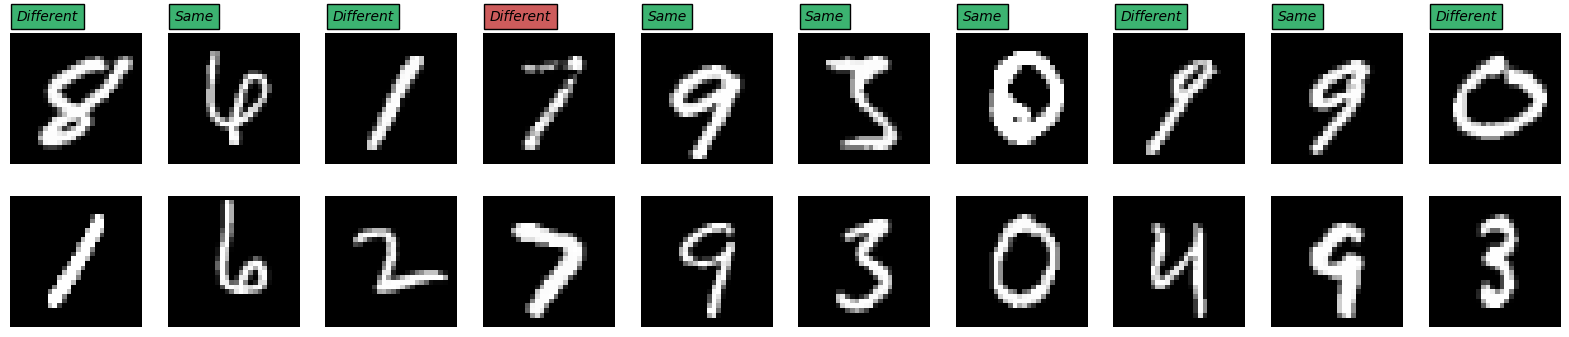

In [25]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_pairs(X_test_pairs, predictions, predictions == y_test_pairs)

In [26]:
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


In [27]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [28]:
digits = np.where(y_test == 3)[0]
index1 = np.random.choice(digits)
index2 = np.random.choice(digits)
index3 = np.random.choice(np.where(y_test == 7)[0])

index1, index2, index3

(6636, 309, 8302)

In [29]:
embedding_model = model.layers[2]


In [30]:
embedding1 = embedding_model.predict(X_test[index1].reshape(1, -1))
embedding2 = embedding_model.predict(X_test[index2].reshape(1, -1))
embedding3 = embedding_model.predict(X_test[index3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
norm(embedding1 - embedding2).numpy()


0.4868701

In [ ]:
norm(embedding1 - embedding3).numpy(), norm(embedding2 - embedding3).numpy()


(0.8675352, 1.0401484)